In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [32]:
df = pd.read_csv(
    "data.csv",
    sep=";",          # correct delimiter
    encoding="latin1",# correct encoding
    decimal=","       # handle 5,00 -> 5.00
)


In [33]:
FEATURES = [
    "Sex", "Age", "Arrival mode", "Injury",
    "Mental", "Pain", "NRS_pain",
    "SBP", "DBP", "HR", "RR", "BT", "Saturation"
]

TARGET = "KTAS_expert"

df = df[FEATURES + [TARGET]]
df = df.dropna(subset=[TARGET])
# convert saturation to numeric
df["Saturation"] = pd.to_numeric(df["Saturation"], errors='coerce')
# replace missing Saturation values with the median
df["Saturation"] = df["Saturation"].fillna(df["Saturation"].median())
# convert NRS_pain to numeric
df["NRS_pain"] = pd.to_numeric(df["NRS_pain"], errors='coerce')
# replace missing NRS_pain values with the median
df["NRS_pain"] = df["NRS_pain"].fillna(df["NRS_pain"].median())



In [34]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           1267 non-null   int64  
 1   Age           1267 non-null   int64  
 2   Arrival mode  1267 non-null   int64  
 3   Injury        1267 non-null   int64  
 4   Mental        1267 non-null   int64  
 5   Pain          1267 non-null   int64  
 6   NRS_pain      1267 non-null   float64
 7   SBP           1267 non-null   object 
 8   DBP           1267 non-null   object 
 9   HR            1267 non-null   object 
 10  RR            1267 non-null   object 
 11  BT            1267 non-null   object 
 12  Saturation    1267 non-null   float64
 13  KTAS_expert   1267 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 138.7+ KB


,Sex,Age,Arrival mode,Injury,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_expert
0,2,71,3,2,1,1,2.0,160,100,84,18,36.6,100.0,4
1,1,56,3,2,1,1,2.0,137,75,60,20,36.5,98.0,5
2,1,68,2,2,1,1,2.0,130,80,102,20,36.6,98.0,5
3,2,71,1,1,1,1,3.0,139,94,88,20,36.5,98.0,5
4,2,58,3,1,1,1,3.0,91,67,93,18,36.5,98.0,5


In [35]:
def ktas_to_risk(x):
    if x in [1, 2]:
        return "High"
    elif x == 3:
        return "Medium"
    else:
        return "Low"

df["risk_level"] = df[TARGET].apply(ktas_to_risk)
df = df.drop(columns=[TARGET])


In [36]:
# Clean vital signs - force them to numeric, turning non-numeric (like '??') into NaN
vitals = ["SBP", "DBP", "HR", "RR", "BT"]
for col in vitals:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for missing values after coercion
print(df[vitals].isnull().sum())

SBP    25
DBP    29
HR     20
RR     22
BT     18
dtype: int64


In [37]:
 # --- Feature Engineering ---
print("Performing feature engineering...")
    
 # Pulse Pressure = SBP - DBP
df["Pulse_Pressure"] = df["SBP"] - df["DBP"]
    
# Shock Index = HR / SBP
# Avoid division by zero if SBP is 0 or NaN
df["Shock_Index"] = df["HR"] / df["SBP"].replace(0, np.nan)

Performing feature engineering...


In [38]:
X = df.drop(columns=["risk_level"])
y = df["risk_level"]


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [40]:
# Define numeric features and categorical features
numeric_features = [
        "Age", "NRS_pain",
        "SBP", "DBP", "HR", "RR", "BT", "Saturation",
        "Pulse_Pressure", "Shock_Index"
    ]

categorical_features = [
        "Sex", "Arrival mode", "Injury",
        "Mental", "Pain"
    ]

In [41]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42,class_weight='balanced'))
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [43]:
 # --- Hyperparameter Tuning ---
print("Starting Hyperparameter Tuning with GridSearchCV...")
    
    # Define parameter grid
param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    # Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
    
    # Train
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Select best model
best_model = grid_search.best_estimator_

Starting Hyperparameter Tuning with GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best cross-validation score: 0.6290


              precision    recall  f1-score   support

        High       0.58      0.53      0.55        49
         Low       0.72      0.66      0.69       107
      Medium       0.62      0.70      0.66        98

    accuracy                           0.65       254
   macro avg       0.64      0.63      0.64       254
weighted avg       0.66      0.65      0.65       254



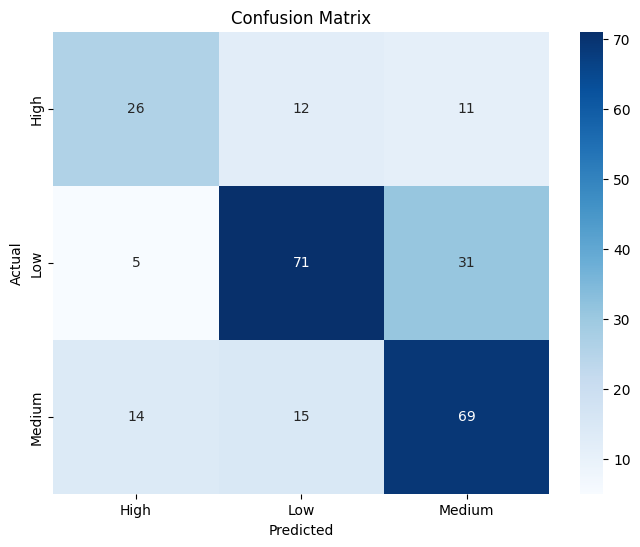

In [44]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = best_model.classes_ if hasattr(best_model, 'classes_') else sorted(y.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
